<a href="https://colab.research.google.com/github/PederRonning/SOK3022/blob/main/Sok_3022_case1_oppgave2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

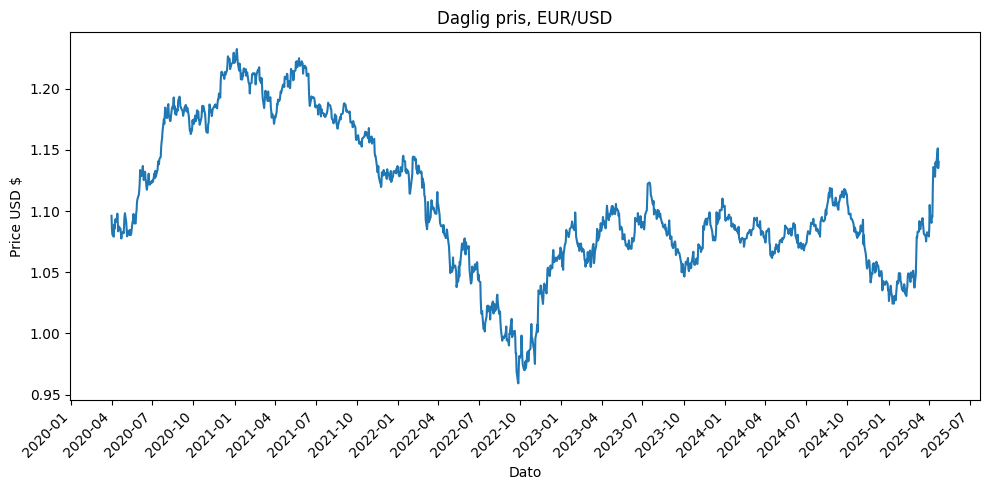

In [34]:
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Read the data

# Les CSV-filen
df = pd.read_csv("EUR_USD Historical Data.csv", parse_dates=["Date"])
df = df.sort_values("Date")

def create_canvas():
    fig, ax = plt.subplots(figsize=(10, 5))

    # Vis bare månedlige «ticks» på dato-aksen
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha="right")

    ax.set_xlabel("Dato")
    ax.set_ylabel("Price USD $")
    ax.set_title("Daglig pris, EUR/USD")

    return ax

ax = create_canvas()

# plot
ax.plot(df["Date"], df["Price"])

# label per kvartal
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))


plt.tight_layout()
plt.show()

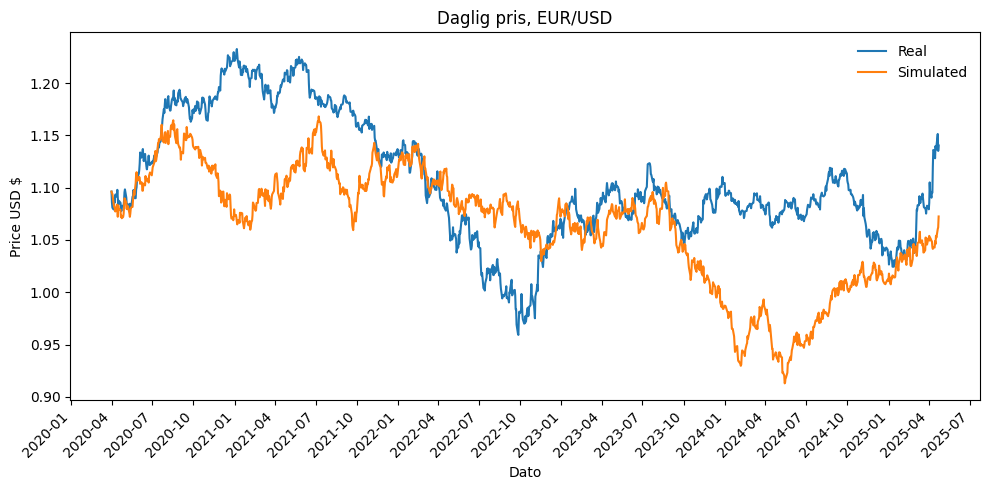

In [35]:
#Simulation:

#Calculating the mean and volatility
mu = np.log(df['Price']).diff().mean()
sigma = np.log(df['Price']).diff().std()

#The Wiener process
dlnS = (mu - 0.5 * sigma**2
            + sigma * np.random.randn(len(df)))

#Ensuring the proces starts at the same point,
#and calulating the level
dlnS[0] = 0
df['Price_sim'] = (df['Price'].iloc[0]
                        * np.exp(np.cumsum(dlnS)))

#plotting:
ax = create_canvas()
ax.plot(df['Date'], df['Price'])
ax.plot(df['Date'], df['Price_sim'])
# label per kvartal
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1,4,7,10)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
ax.legend(['Real', 'Simulated'], frameon=False)

plt.tight_layout()
plt.show()


In [36]:
#Chat gpt er brukt her
from __future__ import annotations

from pathlib import Path
from datetime import timedelta

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import scipy.stats as stats


# -----------------------------------------------------------------------------
# 2. Numerisk Q‑integrasjon à la forelesningsnotatene
# -----------------------------------------------------------------------------

def _lognormal_pdf(ST: np.ndarray, S0: float, sigma: float, mu: float, T: float) -> np.ndarray:
    return (
        1.0 / (ST * sigma * np.sqrt(2 * np.pi * T))
        * np.exp(-(np.log(ST / S0) - (mu - 0.5 * sigma**2) * T) ** 2 / (2 * sigma**2 * T))
    )

def derivative_value_risk_neutral(
    payoff_fn,
    S0: float,
    sigma: float,
    r_dom: float,
    r_for: float,
    T: float,
    N: int = 1000,
    width: float = 5.0,
) -> float:
    """Risikonøytral nåverdi via Gauss‑Legendre integrasjon."""
    mu = r_dom - r_for
    std = sigma * np.sqrt(T)
    a = S0 * np.exp(-width * std)
    b = S0 * np.exp(width * std)

    # Gauss‑Legendre n‑punkts kvadratur
    x, w = np.polynomial.legendre.leggauss(N)
    ST = 0.5 * (x + 1) * (b - a) + a  # transformasjon til [a,b]
    integrand = payoff_fn(ST) * _lognormal_pdf(ST, S0, sigma, mu, T)
    integral = 0.5 * (b - a) * np.sum(w * integrand)
    return float(np.exp(-r_dom * T) * integral)

# -----------------------------------------------------------------------------
# 3. Hent siste observasjon fra FRED (med fallback bakover i tid)
# -----------------------------------------------------------------------------

def latest_fred(series: str, today: pd.Timestamp, lookback: int = 10) -> float:
    """Returnerer siste tilgjengelige verdi siste `lookback` dager.
    Hvis ingen data → raise ValueError."""
    start = today - timedelta(days=lookback)
    df_rate = web.DataReader(series, "fred", start=start, end=today)
    df_rate = df_rate.dropna()
    if df_rate.empty:
        raise ValueError(f"Ingen {series}-data tilgjengelig siste {lookback} dager.")
    return float(df_rate.iloc[-1, 0]) / 100.0

# -----------------------------------------------------------------------------
# 4. Main‑demo
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    csv_path = Path("EUR_USD Historical Data.csv")

    # 4A. Les data og estimer σ
    df = pd.read_csv(csv_path)
    df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")
    df = df.sort_values("Date").reset_index(drop=True)
    S0 = float(df["Price"].iloc[-1])
    log_ret = np.log(df["Price"]).diff().dropna()
    sigma_hat = log_ret.std() * np.sqrt(252)

    # 4B. Risk‑free renter
    today = df["Date"].iloc[-1]
    r_usd = latest_fred("SOFR", today)
    r_eur = latest_fred("ECBESTRVOLWGTTRMDMNRT", today)

    # 4C. Definer kontrakt (ATM call 6 mnd)
    T = 0.5  # år
    K = S0   # at‑the‑money

    def call_payoff(ST: np.ndarray) -> np.ndarray:  # vektorisert
        return np.maximum(ST - K, 0.0)

    # 4D. Priser
    price_num = derivative_value_risk_neutral(call_payoff, S0, sigma_hat, r_usd, r_eur, T)

    print("------- Input -------")
    print(f"Dato           : {today.date()}")
    print(f"S0 (EUR/USD)   : {S0:.4f}")
    print(f"σ annual       : {sigma_hat:.2%}")
    print(f"r_dom (SOFR)   : {r_usd:.2%}")
    print(f"r_for (€STR)   : {r_eur:.2%}\n")

    print("------- Resultater -------")
    print(f"Numerisk integral    : {price_num:.5f} USD per EUR")


------- Input -------
Dato           : 2025-04-23
S0 (EUR/USD)   : 1.1403
σ annual       : 7.47%
r_dom (SOFR)   : 4.30%
r_for (€STR)   : 2.42%

------- Resultater -------
Numerisk integral    : 0.02928 USD per EUR
